In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import vtk
import time
from vtk import vtkStructuredPointsReader
from vtk.util import numpy_support as VN

In [2]:
starttime = time.time()

def getulsit(volumefraction, shearrate):
        # Get and store the filename of ufile
        # path = '/Users/andrewliu/remote_disk/RBC_omp_single/Data/phi_' + volumefraction + '_rate_' + shearrate + '_np_1/data/'
        path = '/Users/andrewliu/Code/IOP/Data/phi_' + volumefraction + '_rate_' + shearrate + '_np_1/data/'
        datalist = os.listdir(path)
        ulist = []
        timeindex = []
        for fn in datalist:
                if fn[0] == 'u': 
                        ulist.append(fn)
                        timeindex.append(float(fn.split('.')[1]))
        # Sort the ulist accorind to time
        ulist = [ulist[i] for i in np.argsort(np.array(timeindex))]
        return ulist, path

def uofrt(ulist, path, bound, direction):
    ut = np.zeros((len(ulist), 2*bound))
    for index, i in enumerate(ulist):
        reader = vtkStructuredPointsReader()
        reader.SetFileName(path + i)
        reader.ReadAllVectorsOn()
        reader.ReadAllScalarsOn()
        reader.Update()
        data = reader.GetOutput()
        u = VN.vtk_to_numpy(data.GetPointData().GetArray('fluid'))
        dim = list(data.GetDimensions())
        ut[index, :] = u[(dim[0]*dim[1]*int(dim[2]/2)+dim[0]*int(dim[1]/2)): (dim[0]*dim[1]*int(dim[2]/2)+dim[0]*int(dim[1]/2) + 2*bound), direction]
    return ut

bounds = [14, 10]
phis = ['493', '982']
shearrates = ['937237e-03', '1405855e-02', '1874474e-02', '3748948e-02']
shearrate = shearrates[3]
direction = 2 # 0 for x, 1 for y, 2 for z
fieldname = ['ux', 'uy', 'uz']

# Calculating here
hydrointer1 = np.zeros((4, 2*bounds[0])) # Max, Min, Avg, RMS
hydrointer2 = np.zeros((4, 2*bounds[1])) # Max, Min, Avg, RMS

for index, phi in enumerate(phis):
    ulist, path = getulsit(phi, shearrate)
    result = uofrt(ulist, path, bounds[index], direction)
    for i in range(2*bounds[index]):
        if shearrate == shearrates[0]:
                if index == 0: uoft = result[800:, i]
                else: uoft = result[600:, i]
        else:   uoft = result[400:, i]

        if index == 0:
                hydrointer1[0, i] = max(uoft)
                hydrointer1[1, i] = min(uoft)
                hydrointer1[2, i] = np.average(uoft)
                hydrointer1[3, i] = np.sqrt(np.mean(np.array(uoft)**2))
        else:
                hydrointer2[0, i] = max(uoft)
                hydrointer2[1, i] = min(uoft)
                hydrointer2[2, i] = np.average(uoft)
                hydrointer2[3, i] = np.sqrt(np.mean(np.array(uoft)**2))
print('Total elapsed time =', time.time() - starttime)

result shape = (801, 28)
result shape = (801, 20)
Total elapsed time = 50.847769021987915


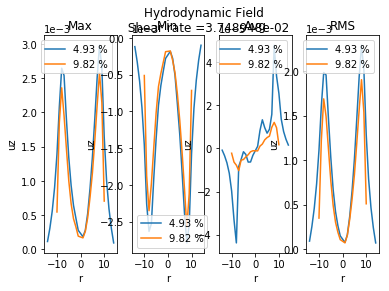

In [14]:
# Make plot
r1 = list(np.arange(-bounds[0], bounds[0]+1))
r1.remove(0)
r2 = list(np.arange(-bounds[1], bounds[1]+1))
r2.remove(0)

subtitle = ['Max', 'Min', 'Avg', 'RMS']
fig, axs = plt.subplots(1, 4)
fig.suptitle('Hydrodynamic Field - {0} \n Shear rate = {1}.{2}'.format(fieldname[direction], shearrate[0], shearrate[1:]), fontsize = 16)
for i in range(4):
    axs[i].plot(r1, hydrointer1[i, :], label = '4.93 %')
    axs[i].plot(r2, hydrointer2[i, :], label = '9.82 %')
    axs[i].set_title(subtitle[i])
    axs[i].ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set(xlabel = 'r', ylabel = fieldname[direction])
    ax.legend()

plt.show()